### **Ejercicio 2.8**
Los barcos llegan a un puerto con tiempos entre llegadas que son variables aleatorias exponenciales IID con una media de 1,25 días. El puerto tiene un muelle con dos amarres y dos grúas para descargar los barcos; los barcos que llegan cuando ambos amarres están ocupados se unen a una cola FIFO. El tiempo para que una grúa descargue un barco se distribuye de manera uniforme entre 0,5 y 1,5 días. Si solo hay un barco en el puerto, ambas grúas descargan el barco y el tiempo de descarga (restante) se reduce a la mitad. Cuando dos barcos están en el puerto, una grúa trabaja en cada barco. Si ambas grúas están descargando un barco cuando llega un segundo barco, una de las grúas comienza inmediatamente a servir al segundo barco y el tiempo de servicio restante del primer barco se duplica. Suponiendo que no haya barcos en el puerto en el momento 0, ejecute la simulación durante 90 días y calcule el tiempo mínimo, máximo y promedio que los barcos están en el puerto (que incluye su tiempo de amarre). También estimar la utilización esperada de cada amarre y de las grúas. Use el flujo 1 para los tiempos de llegada y el flujo 2 para los tiempos de descarga.

In [30]:
!pip install simpy
!pip install pandas

In [31]:
import simpy
import random
import pandas as pd
from tabulate import tabulate

In [ ]:
import simpy
import random
import pandas as pd
import numpy as np
from tabulate import tabulate

# Parámetros de entrada
media = 1.25     # tiempos en días
tiempo_descarga_minimo = 0.5
tiempo_descarga_maximo = 1.5

# Lista para guardar la información de cada simulación
lista_info_sim_base = []

# Ejecutar la simulación 200 veces
for i in range(100):
    # Variables de modelamiento
    env = simpy.Environment()        # ambiente de simulación
    amarres = simpy.Resource(env, capacity=2)                   # se instancian los 2 amarres disponibles
    gruas = simpy.PriorityResource(env, capacity=2)             # se instancian las 2 grúas disponibles con prioridad
    barcos_puerto = 0             # variable contadora de barcos en el puerto
    tiempo_en_puerto = 0          # variable acumuladora de tiempo en el puerto
    utilizacion_amarres = [0, 0]        # variable acumuladora de utilización de amarres
    utilizacion_gruas = [0, 0]              # variable acumuladora de utilización de grúas
    gruas_disponibles = [True, True]        # variable que indica si las grúas están disponibles o no
    tiempo_descarga_por_barco = []          # variable que almacena el tiempo de descarga de cada barco

    # Generador de llegada de barcos
    def llegada_de_barcos(env):
        global barcos_puerto
        while True:
            yield env.timeout(random.expovariate(media)) # tiempo entre llegadas de barcos
            barcos_puerto += 1                                 # se aumenta el contador de barcos en el puerto
            env.process(descargar_barcos(env))                  # se inicia el proceso de descarga de barcos

    # Proceso de descarga de barcos
    def descargar_barcos(env):
        global barcos_puerto, tiempo_en_puerto, gruas_disponibles

        with amarres.request() as amarre:     # se solicita un amarre
            if not (gruas_disponibles[0] and gruas_disponibles[1]): # si no hay grúas disponibles
                tiempo_descarga = random.uniform(tiempo_descarga_minimo, tiempo_descarga_maximo) * 2    # se duplica el tiempo de descarga
            elif barcos_puerto == 1:                             # si es el único barco en el puerto
                tiempo_descarga = random.uniform(tiempo_descarga_minimo, tiempo_descarga_maximo) / 2    # se reduce a la mitad el tiempo de descarga
            else:                                                   # si hay grúas disponibles y hay más de un barco en el puerto
                tiempo_descarga = random.uniform(tiempo_descarga_minimo, tiempo_descarga_maximo)        # generar el tiempo de descarga

            yield amarre
            utilizacion_amarres[amarres.capacity - amarres.count] += env.now    # se acumula el tiempo de utilización de los amarres

            if gruas_disponibles[0]:    # se selecciona la grúa disponible con menor índice
                grua_i = 0      # se selecciona la grúa 0
            else:                       # si la grúa 0 no está disponible
                gruas_disponibles = 1      # se selecciona la grúa 1

            with gruas.request(priority=grua_i) as grua:        # se solicita la grúa seleccionada
                gruas_disponibles[grua_i] = False            # se indica que la grúa seleccionada no está disponible
                yield grua                                    # se espera a que la grúa seleccionada esté disponible

                inicio_descarga = env.now   # se almacena el tiempo de inicio de descarga
                yield env.timeout(tiempo_descarga)  # se espera a que termine la descarga
                fin_descarga = env.now      # se almacena el tiempo de fin de descarga

                gruas_disponibles[grua_i] = True    # se indica que la grúa seleccionada está disponible
                utilizacion_amarres[amarres.capacity - amarres.count] -= env.now   # se acumula el tiempo de utilización de los amarres
                utilizacion_gruas[gruas.capacity - gruas.count] += fin_descarga - inicio_descarga   # se acumula el tiempo de utilización de las grúas

                barcos_puerto -= 1   # se disminuye el contador de barcos en el puerto
                tiempo_en_puerto += tiempo_descarga   # se acumula el tiempo de descarga
                tiempo_descarga_por_barco.append(tiempo_descarga)   # se almacena el tiempo de descarga del barco

    env.process(llegada_de_barcos(env))     # se inicia ela simulacion
    env.run(until=90)                       # se ejecuta la simulacion por 90 dias

    # Calcular medidas de desempeño
    tiempo_promedio = tiempo_en_puerto / len(tiempo_descarga_por_barco)

    if barcos_puerto > 0:
            tiempo_minimo = max(min(tiempo_descarga_por_barco), 0)
            tiempo_maximo = max(max(tiempo_descarga_por_barco), 0)
    else:
            tiempo_minimo = 0
            tiempo_maximo = 0

    utilizacion_amarres = 100 - (100*(round((sum(utilizacion_amarres) / (90 * 24)),4)))
    utilizacion_gruas = 100 - (100*(round((sum(utilizacion_gruas) / (90 * 24)),4)))

    lista_resultados_actual = [tiempo_minimo, tiempo_maximo, tiempo_promedio,
                                utilizacion_amarres, utilizacion_gruas]

    lista_info_sim_base.append(lista_resultados_actual)

    # Presentar los resultados de la simulación actual
    resultados = [
            ["Tiempo mínimo en el puerto:", str(tiempo_minimo)+" dias"  ],
            ["Tiempo máximo en el puerto:", str(tiempo_maximo)+" dias" ],
            ["Tiempo promedio en el puerto:", str(tiempo_promedio)+" dias" ],
            ["---------------------------------------", "----------------------"],
            ["Utilización de amarres (%):", str(utilizacion_amarres) + "  %"],
            ["Utilización de grúas (%):", str(utilizacion_gruas) + "  %"]
        ]

    headers = ["Resultado", "Valor"]

    df = pd.DataFrame(resultados, columns=headers)

    table = tabulate(df, headers='keys', tablefmt='pretty', showindex=False)

    print("\033[1m" + table + "\033[0m")

# Calcular el promedio de las medidas de desempeño
promedio_utilizacion_amarres = sum(info[3] for info in lista_info_sim_base) / len(lista_info_sim_base)
promedio_utilizacion_gruas = sum(info[4] for info in lista_info_sim_base) / len(lista_info_sim_base)

print("El tiempo estimado de Utilización de amarres es de:", promedio_utilizacion_amarres, "%")
print("El tiempo estimado de Utilización de grúas es de:", promedio_utilizacion_gruas, "%")
print("Se ha realizado la simulación", len(lista_info_sim_base), "veces.")


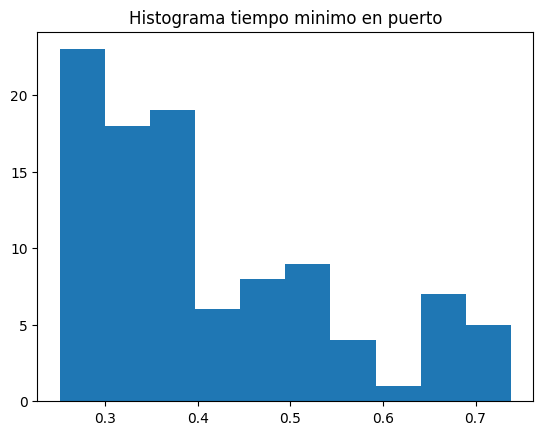

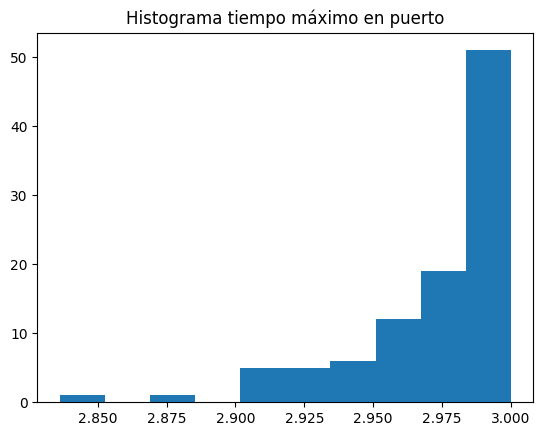

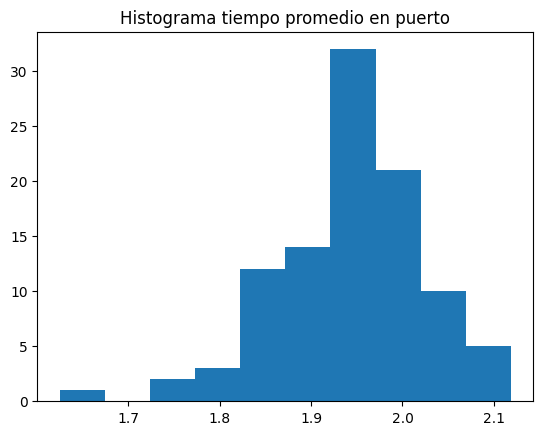

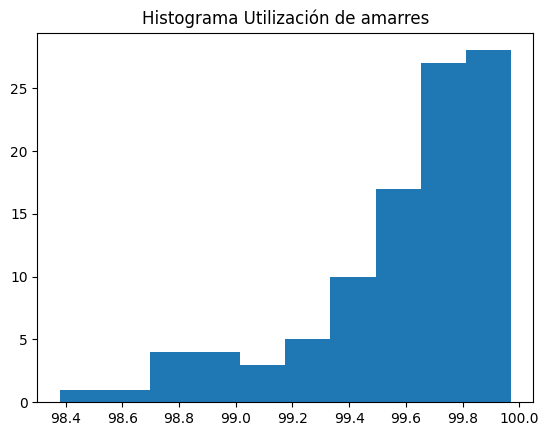

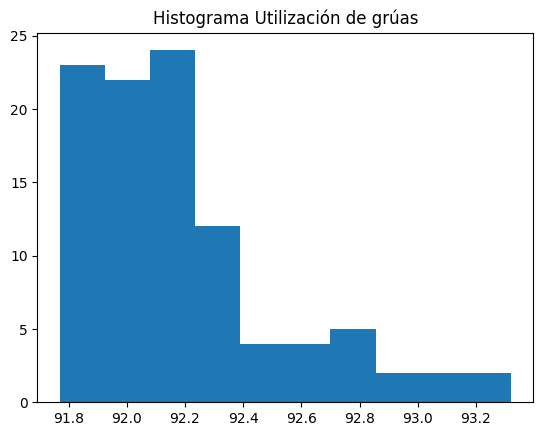

In [71]:
import numpy as np
import matplotlib.pyplot as plt

#lista_info_sim_base

#Graph display
temp_list = [lista_info_sim_base[i][0]for i in range (len(lista_info_sim_base))]
plt.title("Histograma tiempo minimo en puerto")
plt.hist(temp_list, 10, density = False)
plt.show()
temp_list = [lista_info_sim_base[i][1]for i in range (len(lista_info_sim_base))]
plt.title("Histograma tiempo máximo en puerto")
plt.hist(temp_list, 10, density = False)
plt.show()
temp_list = [lista_info_sim_base[i][2]for i in range (len(lista_info_sim_base))]
plt.title("Histograma tiempo promedio en puerto")
plt.hist(temp_list, 10, density = False)
plt.show()
temp_list = [lista_info_sim_base[i][3]for i in range (len(lista_info_sim_base))]
plt.title("Histograma Utilización de amarres")
plt.hist(temp_list, 10, density = False)
plt.show()
temp_list = [lista_info_sim_base[i][4]for i in range (len(lista_info_sim_base))]
plt.title("Histograma Utilización de grúas")
plt.hist(temp_list, 10, density = False)
plt.show()

### **Cambio Propuesto**
Se cambia el tiempo medio de llegada de barcos a 2 días

In [ ]:
import simpy
import random
import pandas as pd
import numpy as np
from tabulate import tabulate

# Parámetros de entrada
media_llegada_barcos = 2     # tiempos en días
tiempo_descarga_minimo = 0.5
tiempo_descarga_maximo = 1.0

# Lista para guardar la información de cada simulación
lista_info_sim_propuesta = []  #Lista para guardar la informacion de la simulacion con alteraciones en parámetros.

# Ejecutar la simulación 200 veces
for i in range(50):
    # Variables de modelamiento
    env = simpy.Environment()        # ambiente de simulación
    amarres = simpy.Resource(env, capacity=2)                   # se instancian los 2 amarres disponibles
    gruas = simpy.PriorityResource(env, capacity=2)             # se instancian las 2 grúas disponibles con prioridad
    barcos_en_puerto = 0             # variable contadora de barcos en el puerto
    tiempo_total_en_puerto = 0          # variable acumuladora de tiempo en el puerto
    utilizacion_amarres = [0, 0]        # variable acumuladora de utilización de amarres
    utilizacion_gruas = [0, 0]              # variable acumuladora de utilización de grúas
    gruas_disponibles = [True, True]        # variable que indica si las grúas están disponibles o no
    tiempo_descarga_por_barco = []          # variable que almacena el tiempo de descarga de cada barco

    # Generador de llegada de barcos
    def llegada_de_barcos(env):
        global barcos_en_puerto
        while True:
            yield env.timeout(random.expovariate(media_llegada_barcos)) # tiempo entre llegadas de barcos
            barcos_en_puerto += 1                                 # se aumenta el contador de barcos en el puerto
            env.process(descargar_barcos(env))                  # se inicia el proceso de descarga de barcos

    # Proceso de descarga de barcos
    def descargar_barcos(env):
        global barcos_en_puerto, tiempo_total_en_puerto, gruas_disponibles

        with amarres.request() as amarre:     # se solicita un amarre
            if not (gruas_disponibles[0] and gruas_disponibles[1]): # si no hay grúas disponibles
                tiempo_descarga = random.uniform(tiempo_descarga_minimo, tiempo_descarga_maximo) * 2    # se duplica el tiempo de descarga
            elif barcos_en_puerto == 1:                             # si es el único barco en el puerto
                tiempo_descarga = random.uniform(tiempo_descarga_minimo, tiempo_descarga_maximo) / 2    # se reduce a la mitad el tiempo de descarga
            else:                                                   # si hay grúas disponibles y hay más de un barco en el puerto
                tiempo_descarga = random.uniform(tiempo_descarga_minimo, tiempo_descarga_maximo)        # generar el tiempo de descarga

            yield amarre
            utilizacion_amarres[amarres.capacity - amarres.count] += env.now    # se acumula el tiempo de utilización de los amarres

            if gruas_disponibles[0]:    # se selecciona la grúa disponible con menor índice
                grua_index = 0      # se selecciona la grúa 0
            else:                       # si la grúa 0 no está disponible
                grua_index = 1      # se selecciona la grúa 1

            with gruas.request(priority=grua_index) as grua:        # se solicita la grúa seleccionada
                gruas_disponibles[grua_index] = False            # se indica que la grúa seleccionada no está disponible
                yield grua                                    # se espera a que la grúa seleccionada esté disponible

                inicio_descarga = env.now   # se almacena el tiempo de inicio de descarga
                yield env.timeout(tiempo_descarga)  # se espera a que termine la descarga
                fin_descarga = env.now      # se almacena el tiempo de fin de descarga

                gruas_disponibles[grua_index] = True    # se indica que la grúa seleccionada está disponible
                utilizacion_amarres[amarres.capacity - amarres.count] -= env.now   # se acumula el tiempo de utilización de los amarres
                utilizacion_gruas[gruas.capacity - gruas.count] += fin_descarga - inicio_descarga   # se acumula el tiempo de utilización de las grúas

                barcos_en_puerto -= 1   # se disminuye el contador de barcos en el puerto
                tiempo_total_en_puerto += tiempo_descarga   # se acumula el tiempo de descarga
                tiempo_descarga_por_barco.append(tiempo_descarga)   # se almacena el tiempo de descarga del barco

    env.process(llegada_de_barcos(env))     # se inicia ela simulacion
    env.run(until=90)                       # se ejecuta la simulacion por 90 dias

    # Calcular medidas de desempeño
    tiempo_promedio_en_puerto = tiempo_total_en_puerto / len(tiempo_descarga_por_barco)

    if barcos_en_puerto > 0:
            tiempo_minimo_en_puerto = max(min(tiempo_descarga_por_barco), 0)
            tiempo_maximo_en_puerto = max(max(tiempo_descarga_por_barco), 0)
    else:
            tiempo_minimo_en_puerto = 0
            tiempo_maximo_en_puerto = 0

    utilizacion_total_amarres = 100 - (100*(round((sum(utilizacion_amarres) / (90 * 24)),4)))
    utilizacion_total_gruas = 100 - (100*(round((sum(utilizacion_gruas) / (90 * 24)),4)))

    lista_resultados_actual = [tiempo_minimo_en_puerto, tiempo_maximo_en_puerto, tiempo_promedio_en_puerto,
                                utilizacion_total_amarres, utilizacion_total_gruas]

    lista_info_sim_propuesta.append(lista_resultados_actual)

    # Presentar los resultados de la simulación actual
    resultados = [
            ["Tiempo mínimo en el puerto:", str(tiempo_minimo_en_puerto)+" dias"  ],
            ["Tiempo máximo en el puerto:", str(tiempo_maximo_en_puerto)+" dias" ],
            ["Tiempo promedio en el puerto:", str(tiempo_promedio_en_puerto)+" dias" ],
            ["---------------------------------------", "----------------------"],
            ["Utilización de amarres (%):", str(utilizacion_total_amarres) + "  %"],
            ["Utilización de grúas (%):", str(utilizacion_total_gruas) + "  %"]
        ]

    headers = ["Resultado", "Valor"]

    df = pd.DataFrame(resultados, columns=headers)

    table = tabulate(df, headers='keys', tablefmt='pretty', showindex=False)

    print("\033[1m" + table + "\033[0m")

# Calcular el promedio de las medidas de desempeño
promedio_utilizacion_amarres = sum(info[3] for info in lista_info_sim_propuesta) / len(lista_info_sim_propuesta)
promedio_utilizacion_gruas = sum(info[4] for info in lista_info_sim_propuesta) / len(lista_info_sim_propuesta)

print("El tiempo estimado de Utilización de amarres es de:", promedio_utilizacion_amarres, "%")
print("El tiempo estimado de Utilización de grúas es de:", promedio_utilizacion_gruas, "%")
print("Se ha realizado la simulación", len(lista_info_sim_propuesta), "veces.")

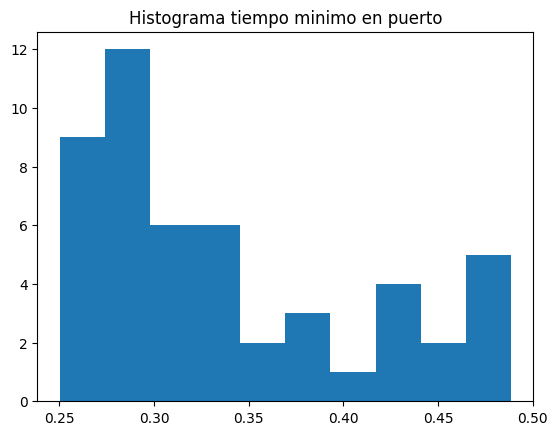

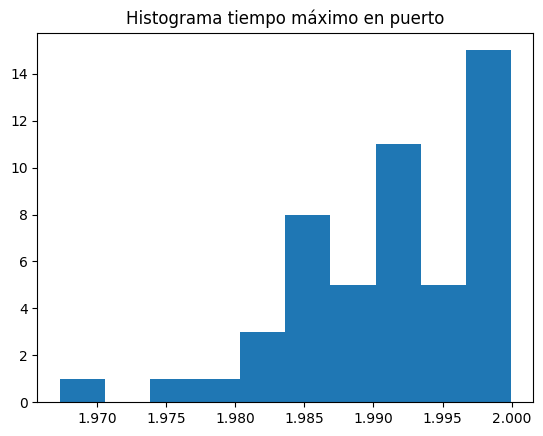

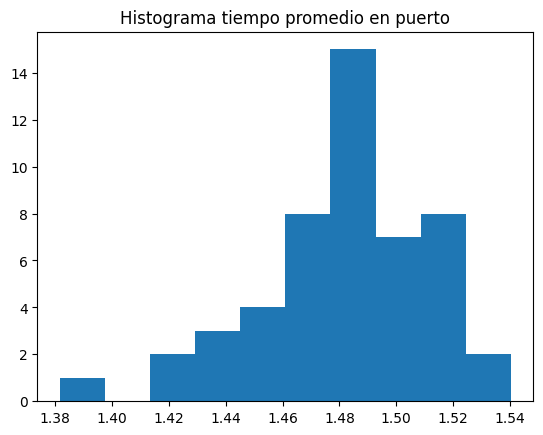

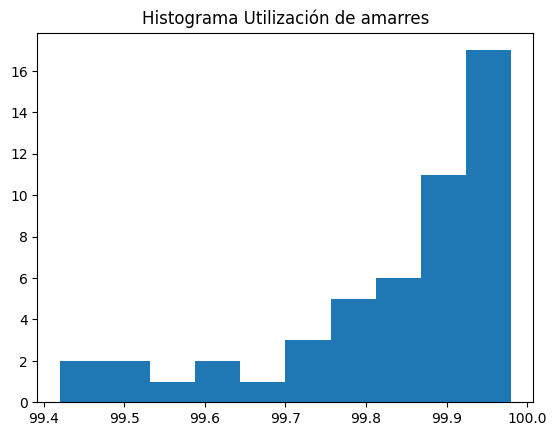

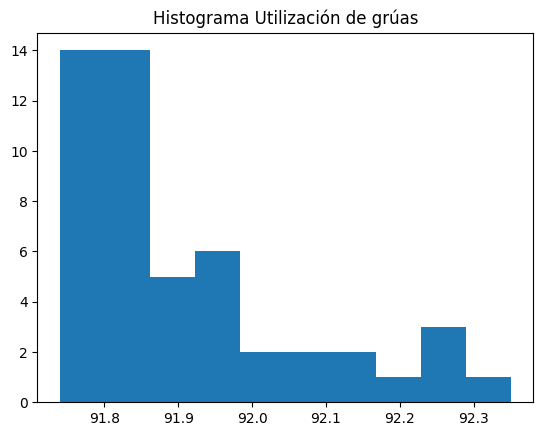

In [99]:
import numpy as np
import matplotlib.pyplot as plt

#lista_info_sim_base

#Graph display
temp_list = [lista_info_sim_propuesta[i][0]for i in range (len(lista_info_sim_propuesta))]
plt.title("Histograma tiempo minimo en puerto")
plt.hist(temp_list, 10, density = False)
plt.show()
temp_list = [lista_info_sim_propuesta[i][1]for i in range (len(lista_info_sim_propuesta))]
plt.title("Histograma tiempo máximo en puerto")
plt.hist(temp_list, 10, density = False)
plt.show()
temp_list = [lista_info_sim_propuesta[i][2]for i in range (len(lista_info_sim_propuesta))]
plt.title("Histograma tiempo promedio en puerto")
plt.hist(temp_list, 10, density = False)
plt.show()
temp_list = [lista_info_sim_propuesta[i][3]for i in range (len(lista_info_sim_propuesta))]
plt.title("Histograma Utilización de amarres")
plt.hist(temp_list, 10, density = False)
plt.show()
temp_list = [lista_info_sim_propuesta[i][4]for i in range (len(lista_info_sim_propuesta))]
plt.title("Histograma Utilización de grúas")
plt.hist(temp_list, 10, density = False)
plt.show()